# PREDICTING INFLUENCER PRICING

In [2]:
%matplotlib inline
import sys
import numpy as np
import pandas as pd
import scipy.stats as stats
import sklearn as sk
import seaborn as sns

import sklearn as sk
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
# from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.pipeline import Pipeline
# from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from sklearn.externals import joblib
import matplotlib.pyplot as plt
import matplotlib.font_manager
sns.set_style("whitegrid")
sns.set_context("poster")
from matplotlib import rcParams

from sklearn.externals import joblib
from flask import Flask, request, jsonify

print('Python version: %s.%s.%s' % sys.version_info[:3])
print('numpy version:', np.__version__)
print('pandas version:', pd.__version__)
print('scikit-learn version:', sk.__version__)

import warnings
warnings.filterwarnings("ignore")

Python version: 3.7.3
numpy version: 1.16.2
pandas version: 0.24.2
scikit-learn version: 0.20.3


For this project, we are estimating the price per influencer.

In [4]:
class EstimatorSelectionHelper:
    
    """
    A helper class for running parameter grid search across different models. 
    It takes two dictionaries. The first contains the models to be scored. 
    The second contains the parameters for each model.
    """
    
    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}
    
   
    
    def fit(self, X, y, cv=3, n_jobs=1, verbose=1, scoring=None, refit=False): 
        """
        fit(X,y) method runs a parameter grid search with cross validation for each model and 
        for the given training data. If scoring=None, the score method of the estimator is used.
        """
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, 
                              verbose=verbose, scoring=scoring, refit=refit)
            gs.fit(X,y)
            self.grid_searches[key] = gs 
    
    
    def score_summary(self, sort_by='mean_score'):            
        """
        After calling fit(X,y), the score_summary() method returns a 
        df with a summary of the scores
        """
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
                }

            return pd.Series(dict(list( params.items()) + list(d.items() ))) #sum up two dicts
                      
        rows = [row(k, gsc.cv_validation_scores, gsc.parameters) 
                for k in self.keys
                for gsc in self.grid_searches[k].grid_scores_]
        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        
        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        
        return df[columns]
        

## Exploring the data

This dataset contains information about 136 user accounts and contains 4 features: 

1. e.price: Price per Post
2. e.followers: Population of Followers
3. e.avglikes: Average Number of Likes 
4. e.avgcomments: Average Number of Comments

e.price will be our target variable.

We have 136 samples in total.

In [5]:
eData = pd.read_csv('cleandata.csv')
eData.columns = ['NUMBER','PRICE', 'FOLLOWERS', 'AVGLIKES','AVGCOMMENTS']

### View pairwise plots between different features

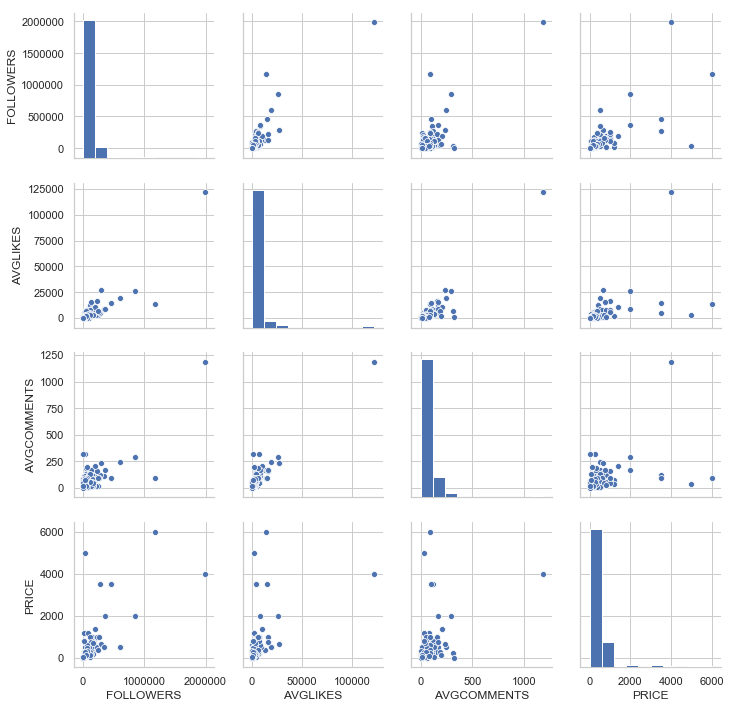

In [7]:
sns.set(style='whitegrid',context='notebook')
cols=['FOLLOWERS','AVGLIKES','AVGCOMMENTS','PRICE']
sns.pairplot(eData[cols],size=2.5)
plt.show()

As you can observe, the majority of our data points are clustered towards lower values.

### CORRELATION MATRIX TO IDENTIFY LINEAR RELATIONSHIPS

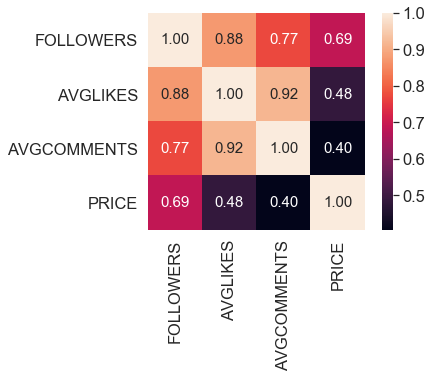

In [8]:
cm = np.corrcoef(eData[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                annot_kws={'size':15},
                yticklabels=cols,
                xticklabels=cols)
plt.show()

Everything is positively correlated.

### FEATURE ANALYSIS

#### PRICE vs FOLLOWERS

Text(0.5, 1.0, 'Relationship between FOLLOWERS and PRICE')

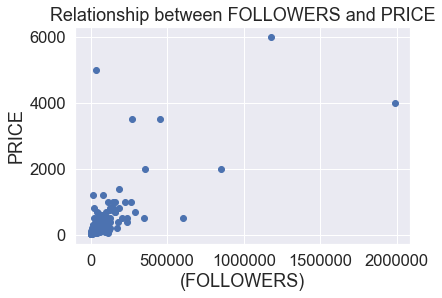

In [9]:
# Plot PRICE vs FOLLOWERS
plt.scatter(eData.FOLLOWERS, eData.PRICE)
plt.xlabel("(FOLLOWERS)")
plt.ylabel("PRICE")
plt.title("Relationship between FOLLOWERS and PRICE")

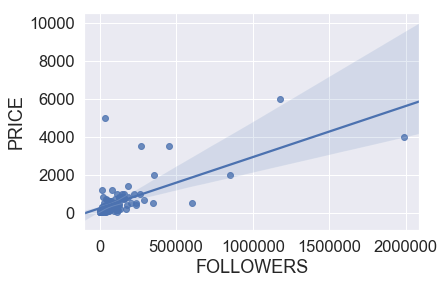

In [10]:
# Using seaborn regplot provides a quick automatic linear regression fit
sns.regplot(y="PRICE", x="FOLLOWERS", data=eData, fit_reg = True)

#### PRICE vs AVGLIKES

Text(0.5, 1.0, 'Relationship between AVGLIKES and PRICE')

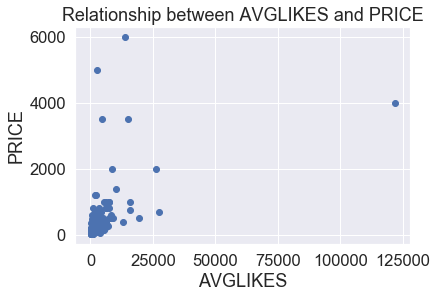

In [11]:
# How price varies as a function of per capita crime rate
plt.scatter(eData.AVGLIKES, eData.PRICE)
plt.xlabel("AVGLIKES")
plt.ylabel("PRICE")
plt.title("Relationship between AVGLIKES and PRICE")

#### PRICE vs COMMENTS

Text(0.5, 1.0, 'Relationship between AVGCOMMENTS and PRICE')

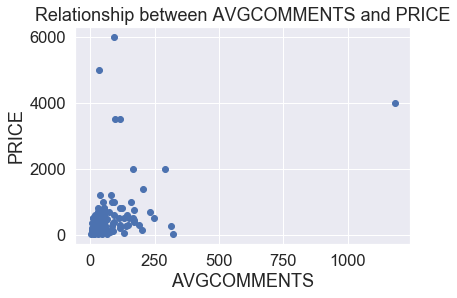

In [12]:
plt.scatter(eData.AVGCOMMENTS, eData.PRICE)
plt.xlabel("AVGCOMMENTS")
plt.ylabel("PRICE")
plt.title("Relationship between AVGCOMMENTS and PRICE")

Let's fit LINEAR, QUADRATIC, and CUBIC polynomial models.

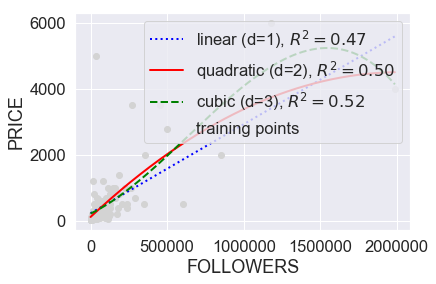

In [13]:
L = eData[['FOLLOWERS']].values
y = eData['PRICE'].values
regr = LinearRegression()

quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
L_quad = quadratic.fit_transform(L)
L_cubic = cubic.fit_transform(L)

# LINEAR
L_fit = np.arange(L.min(), L.max(), 1)[:, np.newaxis]
regr = regr.fit(L,y)
y_lin_fit = regr.predict(L_fit)
linear_r2 = r2_score(y, regr.predict(L))

# QUADRATIC
regr = regr.fit(L_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(L_fit))
quadratic_r2 = r2_score(y, regr.predict(L_quad))

# CUBIC
regr = regr.fit(L_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(L_fit))
cubic_r2 = r2_score(y, regr.predict(L_cubic))

# PLOT
plt.scatter(L, y,
           label='training points',
           color='lightgray')
plt.plot(L_fit, y_lin_fit,
        label='linear (d=1), $R^2=%.2f$'
        % linear_r2,
        color='blue',
        lw=2,
        linestyle=':')
plt.plot(L_fit, y_quad_fit,
        label='quadratic (d=2), $R^2=%.2f$'
        % quadratic_r2,
        color='red',
        lw=2,
        linestyle='-')
plt.plot(L_fit, y_cubic_fit,
        label='cubic (d=3), $R^2=%.2f$'
        % cubic_r2,
        color='green',
        lw=2,
        linestyle='--')
plt.xlabel('FOLLOWERS')
plt.ylabel('PRICE')
plt.legend(loc='upper right')
plt.show()

Here a log transform of the FOLLOWERS feature and taking the square root of PRICE would project the data onto a linear feature space. 

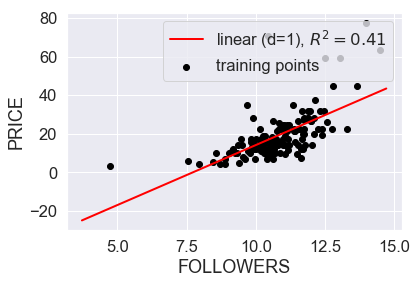

In [14]:
# Transform features
L_log = np.log(L)
y_sqrt = np.sqrt(y)

# Fit features
L_fit = np.arange(L_log.min()-1, L_log.max()+1, 1)[:, np.newaxis]
regr = regr.fit(L_log, y_sqrt)
y_lin_fit = regr.predict(L_fit)
linear_r2 = r2_score(y_sqrt, regr.predict(L_log))

# Plot
plt.scatter(L_log, y_sqrt,
           label='training points',
           color='BLACK')
plt.plot(L_fit, y_lin_fit,
        label='linear (d=1), $R^2=%.2f$'
        % linear_r2,
        color='RED',
        lw=2)

plt.xlabel('FOLLOWERS')
plt.ylabel('PRICE')
plt.legend(loc='upper right')
plt.show()

### Fitting multiple regression models

Fit regression model with some/all features.
Use helper function to select best model and hyperparameters:

In [15]:
# Models to try
models = { 
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'EN': ElasticNet(),
    'RF': RandomForestRegressor(n_estimators=1000),
    'GBR': GradientBoostingRegressor(n_estimators=1000, loss='huber')
}

# Parameters to try (this is not an exahustive GridSearch)

# Note: I'm just throwing linear regression into the GridSearch for comparison
# but not making much of an attempt effort to make it work well 
# by scaling the variables, etc.

params = { 
    'LinearRegression': { }, 
    'Ridge': { 'alpha': [.001, 0.1, 1.0] },
    'Lasso': { 'alpha': [.001, 0.1, 1.0] },
    'EN': { 'alpha': [0.1, 1.0] },
    'RF': {'max_depth': [4,6],
            'min_samples_leaf': [3, 5, 9],
            'max_features': [1.0, 0.3, 0.1]},
    'GBR': {'learning_rate': [0.1, 0.05, 0.02],
              'max_depth': [4, 6],
              'min_samples_leaf': [3, 5, 9],
              'max_features': [1.0, 0.3, 0.1]}
}

In [16]:
X = eData.drop('PRICE', axis=1) # Using all the features
y = eData['PRICE'].values # Target variable

X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=0.3, random_state = 0)

In [17]:
helper = EstimatorSelectionHelper(models, params)
helper.fit(X_train, y_train, n_jobs=-1)

Running GridSearchCV for LinearRegression.
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Running GridSearchCV for Ridge.
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Running GridSearchCV for Lasso.
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Running GridSearchCV for EN.
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Running GridSearchCV for RF.
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   14.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Running GridSearchCV for GBR.
Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:  1.5min finished


In [73]:
helper.score_summary()

,estimator,min_score,mean_score,max_score,std_score,alpha,learning_rate,max_depth,max_features,min_samples_leaf
72,GBR,-0.0754668,0.267645,0.626905,0.286969,NaN,0.02,6,1,3
63,GBR,-0.0881477,0.256606,0.610557,0.285319,NaN,0.02,4,1,3
27,GBR,-0.101177,0.256063,0.609955,0.290328,NaN,0.1,4,1,3
45,GBR,-0.116899,0.251609,0.62854,0.304382,NaN,0.05,4,1,3
42,GBR,-0.189898,0.249493,0.651522,0.344523,NaN,0.1,6,0.1,3
30,GBR,-0.238364,0.247095,0.775994,0.415248,NaN,0.1,4,0.3,3
49,GBR,-0.243063,0.245747,0.723263,0.394582,NaN,0.05,4,0.3,5
70,GBR,-0.229875,0.241996,0.705713,0.381996,NaN,0.02,4,0.1,5
79,GBR,-0.224642,0.240253,0.707098,0.380384,NaN,0.02,6,0.1,5
54,GBR,-0.145567,0.240106,0.592901,0.302373,NaN,0.05,6,1,3


The GBRs perform the best.

Optional: Scaling / log transform some of the variables helps fix skew.

Arbitarily set n_estimators (for RandomForest and GBR) to 1000.

Could tune hyperparemeters. For now use GridSearch.

In [18]:
gbr = GradientBoostingRegressor(n_estimators=1000, learning_rate=.05, loss='huber', 
                                max_depth=4,max_features=.3, min_samples_leaf=3)

gbr.fit(X_train, y_train)
y_train_pred = gbr.predict(X_train)
y_test_pred = gbr.predict(X_test)

#### MAE and R^2

In [21]:
print('MAE train: %.3f, test: %.3f' % (
    mean_absolute_error(y_train, y_train_pred),
    mean_absolute_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
    (r2_score(y_train, y_train_pred),
    r2_score(y_test, y_test_pred))))

MAE train: 62.658, test: 362.770
R^2 train: 0.755, test: 0.387


#### Plotting residuals

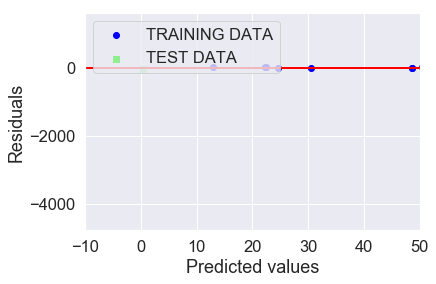

In [22]:
plt.scatter(y_train_pred, y_train_pred-y_train,
           c='blue', marker='o', label='TRAINING DATA')
plt.scatter(y_test_pred, y_test_pred-y_test,
           c='lightgreen', marker='s', label='TEST DATA')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10,50])
plt.show()

With MAE and R^2, we can observe that the model fits training data better than test data.

#### Feature importance

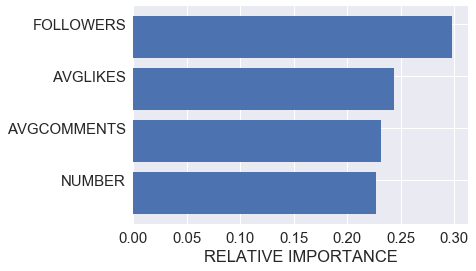

In [77]:
indices = np.argsort(gbr.feature_importances_)
names=list(X.columns.values)
plt.barh(np.arange(len(names)), gbr.feature_importances_[indices])
plt.yticks(np.arange(len(names)) + 0.25, np.array(names)[indices])
_ = plt.xlabel('RELATIVE IMPORTANCE')

Text(0,0.5,'FREQUENCY')

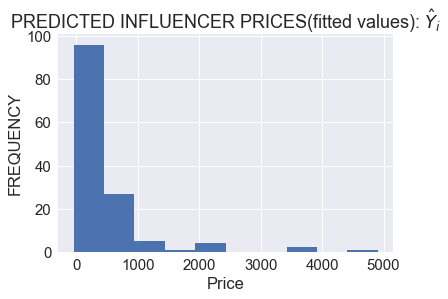

In [78]:
# The distribution of predicted prices
plt.hist(gbr.predict(X))
plt.title('PREDICTED INFLUENCER PRICES(fitted values): $\hat{Y}_i$')
plt.xlabel('Price')
plt.ylabel('FREQUENCY')

#### Plotting predicted prices vs prices:

Text(0.5,1,'PRICES vs PREDICTED PRICES: $Y_i$ vs $\\hat{Y}_i$')

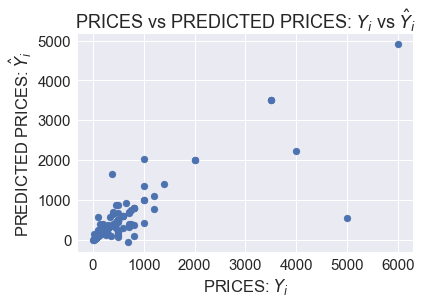

In [79]:
plt.scatter(eData.PRICE, gbr.predict(X))
plt.xlabel("PRICES: $Y_i$")
plt.ylabel("PREDICTED PRICES: $\hat{Y}_i$")
plt.title("PRICES vs PREDICTED PRICES: $Y_i$ vs $\hat{Y}_i$")

In [80]:
# Save the model
model = joblib.dump(gbr, "gbr.pkl")
gbr2 = joblib.load('gbr.pkl')

In [81]:
client1 = [100,36875,751.4348,33.0], # Client 1
gbr2.predict(client1)


array([208.09983027])

In [82]:
client2 = [150,30810,2205.2586,17.344828], # Client 2
gbr2.predict(client2)

array([379.77515332])

In [83]:
client3 = [6000,41486,1397.0233,44.627907], # Client 3
gbr2.predict(client3)

array([252.56354229])

SyntaxError: invalid syntax (<ipython-input-95-82e0d208ee81>, line 108)

## Explore more on GBR

In [ ]:
gbr = GradientBoostingRegressor(n_estimators=1000, learning_rate=.05, loss='huber', 
                                max_depth=4,max_features=.3, min_samples_leaf=3)

gbr.fit(X_train, y_train)
y_train_pred = gbr.predict(X_train)
y_test_pred = gbr.predict(X_test)

In [23]:
#define model as GBR
gbr = GradientBoostingRegressor()

In [24]:
!ls

InfluencerPricing.ipynb influencers_4-20-20.csv
cleandata.csv           user_count_4-20-20.csv


In [120]:
#load raw data
df1 = pd.read_csv('influencers_4-20-20.csv')
df2 = pd.read_csv('user_count_4-20-20.csv')

In [121]:
df1.head()

,id,price_per_post,eprice
0,16,100.0,368.6
1,18,150.0,297.5
2,20,1200.0,495.2
3,36,600.0,173.3
4,37,1200.0,130.7


In [122]:
df2.head()

,id,user_id,social_id,media,follows,followed_by,eng_rate,avg_likes,date,created_at,updated_at,avg_comment,avg_engagement,impressions_week,reach_week
0,1,130,1522729955,644,747,26333,2.579764,679.329193,2017-03-03,2017-03-03 23:25:19,2017-03-03 23:25:19,0.0,0.0,NaN,NaN
1,2,131,352424,2185,3700,85508,1.217503,1041.062700,2017-03-03,2017-03-03 23:25:20,2017-03-03 23:25:20,0.0,0.0,NaN,NaN
2,3,132,233504628,448,2416,103089,2.098897,2163.732143,2017-03-03,2017-03-03 23:25:21,2017-03-03 23:25:21,0.0,0.0,NaN,NaN
3,4,133,357910270,371,3393,56179,1.675018,941.008086,2017-03-03,2017-03-03 23:25:22,2017-03-03 23:25:22,0.0,0.0,NaN,NaN
4,6,136,3546680,5406,227,58569,1.473816,863.199223,2017-03-03,2017-03-03 23:25:24,2017-03-03 23:25:24,0.0,0.0,NaN,NaN


In [64]:
#filter out unnecessary data in df2
df2 = df2.fillna(0)
df2.head()

In [66]:
df2 = df2[~df2['avg_comment'].isin([0])]
df2.head()

,id,user_id,social_id,media,follows,followed_by,eng_rate,avg_likes,date,created_at,updated_at,avg_comment,avg_engagement,impressions_week,reach_week
36062,39085,16,243443488,254,655,42507,2.777921,1119.135135,2017-07-23,2017-07-23 08:00:03,2017-07-23 08:00:03,61.675676,1180.810811,0.0,0.0
36063,39086,18,2047009379,123,170,55736,3.567769,1951.170213,2017-07-23,2017-07-23 08:00:05,2017-07-23 08:00:05,37.361702,1988.531915,0.0,0.0
36064,39088,20,43639467,658,1576,46776,2.492948,1134.768116,2017-07-23,2017-07-23 08:00:07,2017-07-23 08:00:07,31.333333,1166.101449,0.0,0.0
36065,39089,36,838498370,1558,816,66140,2.083734,1347.393939,2017-07-23,2017-07-23 08:00:08,2017-07-23 08:00:08,30.787879,1378.181818,0.0,0.0
36066,39090,37,9146827,1193,943,19958,5.281546,1016.848485,2017-07-23,2017-07-23 08:00:10,2017-07-23 08:00:10,37.242424,1054.090909,0.0,0.0
36067,39091,38,231647705,1214,374,186091,2.389251,4346.575758,2017-07-23,2017-07-23 08:00:11,2017-07-23 08:00:11,99.606061,4446.181818,0.0,0.0
36068,39092,39,17051512,824,267,37253,12.836302,4517.888889,2017-07-23,2017-07-23 08:00:12,2017-07-23 08:00:12,264.018519,4781.907407,0.0,0.0
36069,39093,40,372005869,573,374,201334,2.778412,5542.775510,2017-07-23,2017-07-23 08:00:14,2017-07-23 08:00:14,51.112245,5593.887755,0.0,0.0
36070,39094,41,30512229,775,593,28545,9.705593,2701.780220,2017-07-23,2017-07-23 08:00:15,2017-07-23 08:00:15,68.681319,2770.461538,0.0,0.0
36071,39095,42,12807985,753,199,106427,6.146827,6408.651163,2017-07-23,2017-07-23 08:00:16,2017-07-23 08:00:16,133.232558,6541.883721,0.0,0.0


In [67]:
df2.drop(['impressions_week','reach_week'],axis = 1)
df2.head()

,id,user_id,social_id,media,follows,followed_by,eng_rate,avg_likes,date,created_at,updated_at,avg_comment,avg_engagement
36062,39085,16,243443488,254,655,42507,2.777921,1119.135135,2017-07-23,2017-07-23 08:00:03,2017-07-23 08:00:03,61.675676,1180.810811
36063,39086,18,2047009379,123,170,55736,3.567769,1951.170213,2017-07-23,2017-07-23 08:00:05,2017-07-23 08:00:05,37.361702,1988.531915
36064,39088,20,43639467,658,1576,46776,2.492948,1134.768116,2017-07-23,2017-07-23 08:00:07,2017-07-23 08:00:07,31.333333,1166.101449
36065,39089,36,838498370,1558,816,66140,2.083734,1347.393939,2017-07-23,2017-07-23 08:00:08,2017-07-23 08:00:08,30.787879,1378.181818
36066,39090,37,9146827,1193,943,19958,5.281546,1016.848485,2017-07-23,2017-07-23 08:00:10,2017-07-23 08:00:10,37.242424,1054.090909
36067,39091,38,231647705,1214,374,186091,2.389251,4346.575758,2017-07-23,2017-07-23 08:00:11,2017-07-23 08:00:11,99.606061,4446.181818
36068,39092,39,17051512,824,267,37253,12.836302,4517.888889,2017-07-23,2017-07-23 08:00:12,2017-07-23 08:00:12,264.018519,4781.907407
36069,39093,40,372005869,573,374,201334,2.778412,5542.775510,2017-07-23,2017-07-23 08:00:14,2017-07-23 08:00:14,51.112245,5593.887755
36070,39094,41,30512229,775,593,28545,9.705593,2701.780220,2017-07-23,2017-07-23 08:00:15,2017-07-23 08:00:15,68.681319,2770.461538
36071,39095,42,12807985,753,199,106427,6.146827,6408.651163,2017-07-23,2017-07-23 08:00:16,2017-07-23 08:00:16,133.232558,6541.883721


In [80]:
df2=df2.loc[:,['user_id','followed_by','avg_likes','avg_comment']]
df2.head()

,user_id,followed_by,avg_likes,avg_comment
36062,16,42507,1119.135135,61.675676
36063,18,55736,1951.170213,37.361702
36064,20,46776,1134.768116,31.333333
36065,36,66140,1347.393939,30.787879
36066,37,19958,1016.848485,37.242424


In [74]:
df1.head()

,id,price_per_post,eprice
0,16,100.0,368.6
1,18,150.0,297.5
2,20,1200.0,495.2
3,36,600.0,173.3
4,37,1200.0,130.7


In [84]:
df3 = df1
df4 = df2
df5 = pd.merge(df3,df4, how='left', left_on='id', right_on='user_id')
df5.head()

,id,price_per_post,eprice,user_id,followed_by,avg_likes,avg_comment
0,16,100.0,368.6,16.0,42507.0,1119.135135,61.675676
1,16,100.0,368.6,16.0,42532.0,1119.135135,61.675676
2,16,100.0,368.6,16.0,42511.0,1119.135135,61.675676
3,16,100.0,368.6,16.0,42517.0,1119.135135,61.675676
4,16,100.0,368.6,16.0,42546.0,1119.135135,61.675676


In [91]:
df2[df2['user_id']==16].head()

,user_id,followed_by,avg_likes,avg_comment
36062,16,42507,1119.135135,61.675676
36331,16,42532,1119.135135,61.675676
36608,16,42511,1119.135135,61.675676
36888,16,42517,1119.135135,61.675676
37169,16,42546,1119.135135,61.675676


In [123]:
latest = df2.groupby(['user_id']).agg({'created_at':np.max})

In [124]:
latest.count()

created_at    6150
dtype: int64

In [128]:
df2 = pd.merge(df2, latest, on=['user_id', 'created_at'])

In [130]:
df2.head()

,id,user_id,social_id,media,follows,followed_by,eng_rate,avg_likes,date,created_at,updated_at,avg_comment,avg_engagement,impressions_week,reach_week
0,4449,406,11432810,238,550,16018,2.654076,425.129870,2017-03-27,2017-03-27 08:09:06,2017-03-27 08:09:06,0.0,0.0,NaN,NaN
1,6703,168,314867432,167,1623,56061,3.981994,2232.345455,2017-04-04,2017-04-04 08:05:16,2017-04-04 08:05:16,0.0,0.0,NaN,NaN
2,7205,444,38308889,715,1077,35064,2.643433,926.893333,2017-04-05,2017-04-05 08:07:40,2017-04-05 08:07:40,0.0,0.0,NaN,NaN
3,8827,421,1678426659,442,1695,17052,2.362572,402.865854,2017-04-10,2017-04-10 08:11:16,2017-04-10 08:11:16,0.0,0.0,NaN,NaN
4,12594,500,2086341630,80,452,128957,3.971056,5120.954545,2017-04-21,2017-04-21 08:07:45,2017-04-21 08:07:45,0.0,0.0,NaN,NaN


In [148]:
df3 = df1
df4 = df2
df5 = pd.merge(df3,df4, how='left', left_on='id', right_on='user_id')
df5.head()

,id_x,price_per_post,eprice,id_y,user_id,social_id,media,follows,followed_by,eng_rate,avg_likes,date,created_at,updated_at,avg_comment,avg_engagement,impressions_week,reach_week
0,16,100.0,368.6,740773.0,16.0,3.474889e+09,55.0,504.0,20136.0,10.578897,2073.833333,2020-04-09,2020-04-09 01:00:10,2020-04-09 04:31:36,56.333333,2130.166667,0.0,0.0
1,18,150.0,297.5,740774.0,18.0,2.047009e+09,279.0,49.0,43727.0,0.434895,177.333333,2020-04-09,2020-04-09 01:00:10,2020-04-09 01:00:10,12.833333,190.166667,0.0,0.0
2,20,1200.0,495.2,744458.0,20.0,4.363947e+07,1300.0,1132.0,190539.0,0.000000,0.000000,2020-04-09,2020-04-09 21:36:25,2020-04-09 21:36:25,0.000000,0.000000,0.0,0.0
3,36,600.0,173.3,775149.0,36.0,8.384984e+08,1855.0,961.0,134936.0,2.994373,3994.783784,2020-04-21,2020-04-21 01:00:07,2020-04-21 01:00:07,45.702703,4040.486486,0.0,0.0
4,37,1200.0,130.7,740776.0,37.0,9.146827e+06,3.0,1455.0,96799.0,0.000000,0.000000,2020-04-09,2020-04-09 01:00:10,2020-04-09 01:00:10,0.000000,0.000000,0.0,0.0


In [149]:
df5 = df5.loc[:,['user_id','price_per_post','eprice','followed_by','avg_likes','avg_comment']]
df5.head()

,user_id,price_per_post,eprice,followed_by,avg_likes,avg_comment
0,16.0,100.0,368.6,20136.0,2073.833333,56.333333
1,18.0,150.0,297.5,43727.0,177.333333,12.833333
2,20.0,1200.0,495.2,190539.0,0.000000,0.000000
3,36.0,600.0,173.3,134936.0,3994.783784,45.702703
4,37.0,1200.0,130.7,96799.0,0.000000,0.000000


In [150]:
#number of influencers that doesn't have data of 'avg_likes' and 'avg_comment'
df5[df5['avg_likes']==0].count()

user_id           365
price_per_post    365
eprice            365
followed_by       365
avg_likes         365
avg_comment       365
dtype: int64

In [155]:
#number of influencers tha have full data
df5 = df5[~((df5['avg_likes']==0) | (df5['followed_by']==0) )]
df5.count()

user_id           5784
price_per_post    5784
eprice            5784
followed_by       5784
avg_likes         5784
avg_comment       5784
dtype: int64

## Data preprocessing finished
### Going to apply models on this data
### data = df5 , data size is 6149

In [159]:
df6 = df5
df6['user_id'] = df6['user_id'].astype(int)

In [161]:
df6['followed_by'] = df6['followed_by'].astype(int)
df6.head()

,user_id,price_per_post,eprice,followed_by,avg_likes,avg_comment
0,16,100.0,368.6,20136,2073.833333,56.333333
1,18,150.0,297.5,43727,177.333333,12.833333
3,36,600.0,173.3,134936,3994.783784,45.702703
5,38,800.0,12.2,194,8.000000,1.000000
6,39,250.0,272.8,43385,2317.000000,116.166667


## df5.to_csv('LData.csv', index=False)

In [222]:
#split dataset
X = df6.loc[:,['followed_by','avg_likes','avg_comment']]
y = df6.loc[:,['price_per_post']]
X_train, X_test, y_train, y_test = \
    train_test_split(X,y, test_size = 0.2, random_state=0)

In [223]:
#normalize data
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)
# y_train = std.fit_transform(y_train)
# y_test = std.transform(y_test)

In [224]:
#define model
gbr = GradientBoostingRegressor()

In [225]:
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [226]:
prediction = gbr.predict(X_test)

In [231]:
y_train_prediction = gbr.predict(X_train)

In [232]:
print('MAE train: %.3f, test: %.3f' % (
    mean_absolute_error(y_train, y_train_prediction),
    mean_absolute_error(y_test, prediction)))
print('R^2 train: %.3f, test: %.3f' % (
    (r2_score(y_train, y_train_prediction),
    r2_score(y_test, prediction))))

MAE train: 168.934, test: 188.465
R^2 train: 0.527, test: -0.232


In [239]:
joblib.dump(gbr, 'GBRmodel.pkl')

['GBRmodel.pkl']

## Deal with training data
#### Delete rows without 'price_per_post'

In [246]:
#remove rows without 'price_per_post'
df6 = df6[~(df6['price_per_post']==0)]

In [247]:
X = df6.loc[:,['followed_by','avg_comment','avg_likes']]
y = df6.loc[:,'price_per_post']

In [249]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size = 0.2, random_state = 0)

In [251]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)

In [252]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [253]:
predictions = gbr.predict(X_test)

In [254]:
y_train_predictions = gbr.predict(X_train)

In [255]:
print('MAE train: %.3f, test: %.3f' % (
    mean_absolute_error(y_train, y_train_predictions),
    mean_absolute_error(y_test, predictions)))
print('R^2 train: %.3f, test: %.3f' % (
    (r2_score(y_train, y_train_predictions),
    r2_score(y_test, predictions))))

MAE train: 183.479, test: 210.353
R^2 train: 0.670, test: -0.077
